In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import wandb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

os.environ['WANDB_DIR'] = 'wb_logs'
# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Probe Models

We've trained two types of probes:

1. **Linear Probe**: A simple linear layer that predicts linguistic features
2. **Non-linear Probe**: A two-layer neural network with ReLU activation

In addition, we trained several baselines:

3. **Shuffled**: Probes with shuffled target tables
4. **Random Predictions**: Randomly pick a target class
5. **Random Representations**: Generate the representation at random instead of using the embedding

These probes will be trained to predict:
- Part-of-speech (POS) tags
- Dependency relations (Universal Dependency Tags)

In [3]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


class NonlinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)


# Define a random baseline probe for comparison
class RandomPredictionProbe(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

    def forward(self, x):
        return torch.randint(0, self.n_classes, (x.size(0),), device=x.device)

## 2. Evaluation Functions

In [ ]:
def load_embedding_artifacts():
    embedding_artifact_names = {
        "E5": "mech_decomp/mechanistic-decomposition-sentence-embeddings/embeddings-multilingual-e5-large:latest",
        "MPNET": "mech_decomp/mechanistic-decomposition-sentence-embeddings/embeddings-all-mpnet-base-v2:latest",
        "MiniLM": 'mech_decomp/mechanistic-decomposition-sentence-embeddings/embeddings-all-MiniLM-L6-v2:latest',
    }

    embedding_dirs = {}
    for name, artifact_path in embedding_artifact_names.items():
        run = wandb.init(project="mechanistic-decomposition-sentence-embeddings", reinit=True)
        artifact = run.use_artifact(artifact_path, type="embeddings")
        artifact_dir = artifact.download()
        embedding_dirs[name] = artifact_dir
        run.finish()

    return embedding_dirs

# Usage
embedding_dirs = load_embedding_artifacts()
print(embedding_dirs)

In [7]:
import os
import glob
import pandas as pd
import pickle

def load_embeddings_from_dirs(embedding_dirs):
    """
    Loads both CSV and pickle files for each embedding model from their respective artifact directories.
    
    Returns a dict of the form:
    {
        "E5": {"csv": df, "pkl": embeddings},
        "GTE": {"csv": df, "pkl": embeddings},
        ...
    }
    """
    all_embeddings = {}

    for name, dir_path in embedding_dirs.items():
        # Find the CSV file
        csv_files = glob.glob(os.path.join(dir_path, "*.csv"))
        pkl_files = glob.glob(os.path.join(dir_path, "*.pkl"))

        if not csv_files:
            raise FileNotFoundError(f"No CSV file found in {dir_path}")
        if not pkl_files:
            raise FileNotFoundError(f"No pickle file found in {dir_path}")

        csv_path = csv_files[0]
        pkl_path = pkl_files[0]

        df = pd.read_csv(csv_path)
        with open(pkl_path, "rb") as f:
            embeddings = pickle.load(f)

        df['embedding'] = [embeddings[idx] for idx in df['embedding_idx']]

        all_embeddings[name] = {"csv": df, "pkl": embeddings}

    return all_embeddings

embedding_data = load_embeddings_from_dirs(embedding_dirs)

In [44]:
def evaluate_probe(model, X, y):
    """Evaluate a classification probe."""
    model.eval()
    with torch.no_grad():
        if isinstance(model, RandomPredictionProbe):
            preds = model(X)
        else:
            preds = model(X).argmax(dim=1)
        accuracy = (preds == y).float().mean().item()
    return accuracy

def train_probe(model, X_train, y_train, X_val, y_val, task_name="TASK", epochs=10, output_dir="trained_models"):
    """
    Train a classification probe with validation.
    
    Args:
        model: The probe model to train
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        task_name: Name of the task for logging
        epochs: Number of training epochs
        output_dir: Directory to save the model
        
    Returns:
        model: Trained model
        history: Dictionary with training history
    """
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    history = {
        'train_loss': [],
        'val_accuracy': []
    }

    best_val_acc = 0.0
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in tqdm(loader, desc=f"{task_name} Epoch {epoch+1}", leave=False):
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Evaluate on validation set
        val_accuracy = evaluate_probe(model, X_val, y_val)
        
        # Save history
        history['train_loss'].append(total_loss / len(loader))
        history['val_accuracy'].append(val_accuracy)
        
        print(f"{task_name} - Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return model, history

def run_all_probes_and_controls(X, y_pos, y_dep, le_pos, le_dep, hidden_dim=128, test_size=0.2, output_dir="trained_models"):
    """
    Run all probes and control experiments with train-test split.
    
    Args:
        X: Input features tensor
        y_pos: POS tag labels tensor
        y_dep: Dependency relation labels tensor
        le_pos: Label encoder for POS tags
        le_dep: Label encoder for dependency relations
        hidden_dim: Hidden dimension for nonlinear probes
        test_size: Fraction of data to use for testing
        output_dir: Directory to save trained models
        
    Returns:
        results: Dictionary with evaluation results
        probes: Dictionary with trained probe models
    """
    # Create train-test split
    n_samples = X.shape[0]
    indices = torch.randperm(n_samples)
    train_size = int((1 - test_size) * n_samples)
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_pos_train, y_pos_test = y_pos[train_indices], y_pos[test_indices]
    y_dep_train, y_dep_test = y_dep[train_indices], y_dep[test_indices]
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Dictionary to store all trained probes
    probes = {}
    
    # === Main Probes ===
    print("\n=== Training Main Probes ===")
    pos_model, pos_history = train_probe(
        LinearProbe(X.shape[1], len(le_pos.classes_)), 
        X_train, y_pos_train, X_test, y_pos_test, 
        "POS", output_dir=output_dir
    )
    probes["pos_linear"] = pos_model
    
    dep_model, dep_history = train_probe(
        LinearProbe(X.shape[1], len(le_dep.classes_)), 
        X_train, y_dep_train, X_test, y_dep_test, 
        "DEP", output_dir=output_dir
    )
    probes["dep_linear"] = dep_model

    # === Nonlinear Probes ===
    print("\n=== Training Nonlinear Probes ===")
    pos_nonlinear, pos_nl_history = train_probe(
        NonlinearProbe(X.shape[1], len(le_pos.classes_), hidden_dim=hidden_dim), 
        X_train, y_pos_train, X_test, y_pos_test, 
        "POS_Nonlinear", output_dir=output_dir
    )
    probes["pos_nonlinear"] = pos_nonlinear
    
    dep_nonlinear, dep_nl_history = train_probe(
        NonlinearProbe(X.shape[1], len(le_dep.classes_), hidden_dim=hidden_dim), 
        X_train, y_dep_train, X_test, y_dep_test, 
        "DEP_Nonlinear", output_dir=output_dir
    )
    probes["dep_nonlinear"] = dep_nonlinear

    # === Random Baselines ===
    print("\n=== Evaluating Random Baselines ===")
    pos_random = RandomPredictionProbe(len(le_pos.classes_))
    probes["pos_random"] = pos_random
    
    dep_random = RandomPredictionProbe(len(le_dep.classes_))
    probes["dep_random"] = dep_random

    # === Shuffled Labels ===
    print("\n=== Training with Shuffled Labels ===")
    pos_shuffled, pos_sh_history = train_probe(
        LinearProbe(X.shape[1], len(le_pos.classes_)), 
        X_train, y_pos_train[torch.randperm(len(y_pos_train))], 
        X_test, y_pos_test, 
        "POS_Shuffled", output_dir=output_dir
    )
    probes["pos_shuffled"] = pos_shuffled
    
    dep_shuffled, dep_sh_history = train_probe(
        LinearProbe(X.shape[1], len(le_dep.classes_)), 
        X_train, y_dep_train[torch.randperm(len(y_dep_train))], 
        X_test, y_dep_test, 
        "DEP_Shuffled", output_dir=output_dir
    )
    probes["dep_shuffled"] = dep_shuffled

    # === Random Representations ===
    print("\n=== Training with Random Representations ===")
    X_rand_train = torch.randn_like(X_train)
    X_rand_test = torch.randn_like(X_test)
    
    pos_randrep, pos_rr_history = train_probe(
        LinearProbe(X.shape[1], len(le_pos.classes_)), 
        X_rand_train, y_pos_train, X_rand_test, y_pos_test, 
        "POS_RandomRep", output_dir=output_dir
    )
    probes["pos_random_rep"] = pos_randrep
    
    dep_randrep, dep_rr_history = train_probe(
        LinearProbe(X.shape[1], len(le_dep.classes_)), 
        X_rand_train, y_dep_train, X_rand_test, y_dep_test, 
        "DEP_RandomRep", output_dir=output_dir
    )
    probes["dep_random_rep"] = dep_randrep

    # === Evaluation on Test Set ===
    print("\n=== Evaluation on Test Set ===")
    results = {
        "POS": {
            "linear": evaluate_probe(pos_model, X_test, y_pos_test),
            "nonlinear": evaluate_probe(pos_nonlinear, X_test, y_pos_test),
            "random": evaluate_probe(pos_random, X_test, y_pos_test),
            "shuffled": evaluate_probe(pos_shuffled, X_test, y_pos_test),
            "random_rep": evaluate_probe(pos_randrep, X_rand_test, y_pos_test)
        },
        "DEP": {
            "linear": evaluate_probe(dep_model, X_test, y_dep_test),
            "nonlinear": evaluate_probe(dep_nonlinear, X_test, y_dep_test),
            "random": evaluate_probe(dep_random, X_test, y_dep_test),
            "shuffled": evaluate_probe(dep_shuffled, X_test, y_dep_test),
            "random_rep": evaluate_probe(dep_randrep, X_rand_test, y_dep_test)
        }
    }
    
    # Print results table
    print("\nResults Summary:")
    print("-" * 60)
    print(f"{'Task':<10} {'Method':<15} {'Accuracy':<10}")
    print("-" * 60)
    
    for task, task_results in results.items():
        for method, accuracy in task_results.items():
            print(f"{task:<10} {method:<15} {accuracy:.4f}")
    
    return results, probes

In [45]:
from sklearn.preprocessing import LabelEncoder

def get_data_for_model(model_name):
    df = embedding_data[model_name]['csv']
    X = torch.stack(df['embedding'].tolist())
    
    le_pos = LabelEncoder().fit(df["pos"])
    le_dep = LabelEncoder().fit(df["dep"])
    
    y_pos = torch.tensor(le_pos.transform(df['pos'].values))
    y_dep = torch.tensor(le_dep.transform(df['dep'].values))
    return df, X, le_pos, le_dep, y_pos, y_dep

def run_for_model(model_name):
    df, X, le_pos, le_dep, y_pos, y_dep = get_data_for_model(model_name)
    results, probes = run_all_probes_and_controls(X, y_pos, y_dep, le_pos, le_dep)
    return results, probes

eval_results = {}
probes = {}
for model_name in embedding_data.keys():
    results, probes = run_for_model('MiniLM')
    eval_results[model_name] = results
    probes[model_name] = probes

Train set: 16000 samples
Test set: 4000 samples

=== Training Main Probes ===


POS Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 1, Loss: 1.8887, Val Accuracy: 0.6837


POS Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 2, Loss: 1.1595, Val Accuracy: 0.7435


POS Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 3, Loss: 0.9196, Val Accuracy: 0.7837


POS Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 4, Loss: 0.7920, Val Accuracy: 0.8005


POS Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 5, Loss: 0.7106, Val Accuracy: 0.8108


POS Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 6, Loss: 0.6530, Val Accuracy: 0.8160


POS Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 7, Loss: 0.6095, Val Accuracy: 0.8223


POS Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 8, Loss: 0.5751, Val Accuracy: 0.8320


POS Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 9, Loss: 0.5467, Val Accuracy: 0.8347


POS Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 10, Loss: 0.5234, Val Accuracy: 0.8405


DEP Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 1, Loss: 2.7455, Val Accuracy: 0.5002


DEP Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 2, Loss: 1.9218, Val Accuracy: 0.5495


DEP Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 3, Loss: 1.6434, Val Accuracy: 0.5800


DEP Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 4, Loss: 1.4869, Val Accuracy: 0.5995


DEP Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 5, Loss: 1.3821, Val Accuracy: 0.6093


DEP Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 6, Loss: 1.3054, Val Accuracy: 0.6175


DEP Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 7, Loss: 1.2457, Val Accuracy: 0.6267


DEP Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 8, Loss: 1.1970, Val Accuracy: 0.6340


DEP Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 9, Loss: 1.1566, Val Accuracy: 0.6390


DEP Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 10, Loss: 1.1221, Val Accuracy: 0.6455

=== Training Nonlinear Probes ===


POS_Nonlinear Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 1, Loss: 1.2989, Val Accuracy: 0.7905


POS_Nonlinear Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 2, Loss: 0.5677, Val Accuracy: 0.8450


POS_Nonlinear Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 3, Loss: 0.4288, Val Accuracy: 0.8633


POS_Nonlinear Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 4, Loss: 0.3566, Val Accuracy: 0.8700


POS_Nonlinear Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 5, Loss: 0.3062, Val Accuracy: 0.8760


POS_Nonlinear Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 6, Loss: 0.2684, Val Accuracy: 0.8773


POS_Nonlinear Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 7, Loss: 0.2364, Val Accuracy: 0.8830


POS_Nonlinear Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 8, Loss: 0.2128, Val Accuracy: 0.8820


POS_Nonlinear Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 9, Loss: 0.1911, Val Accuracy: 0.8808


POS_Nonlinear Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 10, Loss: 0.1728, Val Accuracy: 0.8848


DEP_Nonlinear Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 1, Loss: 2.2302, Val Accuracy: 0.5757


DEP_Nonlinear Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 2, Loss: 1.3575, Val Accuracy: 0.6275


DEP_Nonlinear Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 3, Loss: 1.1446, Val Accuracy: 0.6507


DEP_Nonlinear Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 4, Loss: 1.0217, Val Accuracy: 0.6690


DEP_Nonlinear Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 5, Loss: 0.9318, Val Accuracy: 0.6765


DEP_Nonlinear Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 6, Loss: 0.8580, Val Accuracy: 0.6770


DEP_Nonlinear Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 7, Loss: 0.7973, Val Accuracy: 0.6733


DEP_Nonlinear Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 8, Loss: 0.7442, Val Accuracy: 0.6758


DEP_Nonlinear Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 9, Loss: 0.6941, Val Accuracy: 0.6835


DEP_Nonlinear Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 10, Loss: 0.6514, Val Accuracy: 0.6768

=== Evaluating Random Baselines ===

=== Training with Shuffled Labels ===


POS_Shuffled Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 1, Loss: 2.5714, Val Accuracy: 0.1468


POS_Shuffled Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 2, Loss: 2.4479, Val Accuracy: 0.1558


POS_Shuffled Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 3, Loss: 2.4109, Val Accuracy: 0.1462


POS_Shuffled Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 4, Loss: 2.3884, Val Accuracy: 0.1468


POS_Shuffled Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 5, Loss: 2.3726, Val Accuracy: 0.1478


POS_Shuffled Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 6, Loss: 2.3605, Val Accuracy: 0.1458


POS_Shuffled Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 7, Loss: 2.3507, Val Accuracy: 0.1405


POS_Shuffled Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 8, Loss: 2.3428, Val Accuracy: 0.1332


POS_Shuffled Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 9, Loss: 2.3362, Val Accuracy: 0.1408


POS_Shuffled Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 10, Loss: 2.3303, Val Accuracy: 0.1332


DEP_Shuffled Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 1, Loss: 3.4170, Val Accuracy: 0.1205


DEP_Shuffled Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 2, Loss: 3.1813, Val Accuracy: 0.1328


DEP_Shuffled Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 3, Loss: 3.1102, Val Accuracy: 0.1285


DEP_Shuffled Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 4, Loss: 3.0652, Val Accuracy: 0.1310


DEP_Shuffled Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 5, Loss: 3.0315, Val Accuracy: 0.1293


DEP_Shuffled Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 6, Loss: 3.0051, Val Accuracy: 0.1277


DEP_Shuffled Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 7, Loss: 2.9828, Val Accuracy: 0.1270


DEP_Shuffled Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 8, Loss: 2.9647, Val Accuracy: 0.1262


DEP_Shuffled Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 9, Loss: 2.9483, Val Accuracy: 0.1265


DEP_Shuffled Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 10, Loss: 2.9344, Val Accuracy: 0.1255

=== Training with Random Representations ===


POS_RandomRep Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 1, Loss: 2.8715, Val Accuracy: 0.1103


POS_RandomRep Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 2, Loss: 2.6351, Val Accuracy: 0.1173


POS_RandomRep Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 3, Loss: 2.5219, Val Accuracy: 0.1258


POS_RandomRep Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 4, Loss: 2.4593, Val Accuracy: 0.1305


POS_RandomRep Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 5, Loss: 2.4211, Val Accuracy: 0.1332


POS_RandomRep Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 6, Loss: 2.3953, Val Accuracy: 0.1385


POS_RandomRep Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 7, Loss: 2.3770, Val Accuracy: 0.1425


POS_RandomRep Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 8, Loss: 2.3639, Val Accuracy: 0.1513


POS_RandomRep Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 9, Loss: 2.3555, Val Accuracy: 0.1505


POS_RandomRep Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 10, Loss: 2.3481, Val Accuracy: 0.1542


DEP_RandomRep Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 1, Loss: 3.8343, Val Accuracy: 0.0573


DEP_RandomRep Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 2, Loss: 3.4837, Val Accuracy: 0.0670


DEP_RandomRep Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 3, Loss: 3.2826, Val Accuracy: 0.0725


DEP_RandomRep Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 4, Loss: 3.1585, Val Accuracy: 0.0740


DEP_RandomRep Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 5, Loss: 3.0787, Val Accuracy: 0.0785


DEP_RandomRep Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 6, Loss: 3.0235, Val Accuracy: 0.0812


DEP_RandomRep Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 7, Loss: 2.9828, Val Accuracy: 0.0810


DEP_RandomRep Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 8, Loss: 2.9520, Val Accuracy: 0.0817


DEP_RandomRep Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 9, Loss: 2.9280, Val Accuracy: 0.0812


DEP_RandomRep Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 10, Loss: 2.9081, Val Accuracy: 0.0830

=== Evaluation on Test Set ===

Results Summary:
------------------------------------------------------------
Task       Method          Accuracy  
------------------------------------------------------------
POS        linear          0.8405
POS        nonlinear       0.8848
POS        random          0.0608
POS        shuffled        0.1332
POS        random_rep      0.1542
DEP        linear          0.6455
DEP        nonlinear       0.6768
DEP        random          0.0225
DEP        shuffled        0.1255
DEP        random_rep      0.0830
Train set: 16000 samples
Test set: 4000 samples

=== Training Main Probes ===


POS Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 1, Loss: 1.8727, Val Accuracy: 0.6963


POS Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 2, Loss: 1.1546, Val Accuracy: 0.7510


POS Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 3, Loss: 0.9151, Val Accuracy: 0.7805


POS Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 4, Loss: 0.7874, Val Accuracy: 0.7960


POS Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 5, Loss: 0.7056, Val Accuracy: 0.8075


POS Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 6, Loss: 0.6479, Val Accuracy: 0.8150


POS Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 7, Loss: 0.6037, Val Accuracy: 0.8232


POS Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 8, Loss: 0.5691, Val Accuracy: 0.8278


POS Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 9, Loss: 0.5409, Val Accuracy: 0.8345


POS Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 10, Loss: 0.5172, Val Accuracy: 0.8363


DEP Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 1, Loss: 2.7455, Val Accuracy: 0.4882


DEP Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 2, Loss: 1.9255, Val Accuracy: 0.5412


DEP Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 3, Loss: 1.6458, Val Accuracy: 0.5658


DEP Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 4, Loss: 1.4892, Val Accuracy: 0.5857


DEP Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 5, Loss: 1.3834, Val Accuracy: 0.6012


DEP Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 6, Loss: 1.3061, Val Accuracy: 0.6130


DEP Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 7, Loss: 1.2458, Val Accuracy: 0.6210


DEP Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 8, Loss: 1.1974, Val Accuracy: 0.6225


DEP Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 9, Loss: 1.1564, Val Accuracy: 0.6305


DEP Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 10, Loss: 1.1220, Val Accuracy: 0.6365

=== Training Nonlinear Probes ===


POS_Nonlinear Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 1, Loss: 1.2973, Val Accuracy: 0.7900


POS_Nonlinear Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 2, Loss: 0.5644, Val Accuracy: 0.8415


POS_Nonlinear Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 3, Loss: 0.4226, Val Accuracy: 0.8587


POS_Nonlinear Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 4, Loss: 0.3494, Val Accuracy: 0.8637


POS_Nonlinear Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 5, Loss: 0.2974, Val Accuracy: 0.8652


POS_Nonlinear Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 6, Loss: 0.2616, Val Accuracy: 0.8727


POS_Nonlinear Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 7, Loss: 0.2300, Val Accuracy: 0.8750


POS_Nonlinear Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 8, Loss: 0.2052, Val Accuracy: 0.8735


POS_Nonlinear Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 9, Loss: 0.1840, Val Accuracy: 0.8783


POS_Nonlinear Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 10, Loss: 0.1654, Val Accuracy: 0.8800


DEP_Nonlinear Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 1, Loss: 2.2222, Val Accuracy: 0.5663


DEP_Nonlinear Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 2, Loss: 1.3611, Val Accuracy: 0.6227


DEP_Nonlinear Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 3, Loss: 1.1457, Val Accuracy: 0.6525


DEP_Nonlinear Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 4, Loss: 1.0185, Val Accuracy: 0.6575


DEP_Nonlinear Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 5, Loss: 0.9289, Val Accuracy: 0.6702


DEP_Nonlinear Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 6, Loss: 0.8544, Val Accuracy: 0.6672


DEP_Nonlinear Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 7, Loss: 0.7932, Val Accuracy: 0.6743


DEP_Nonlinear Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 8, Loss: 0.7414, Val Accuracy: 0.6725


DEP_Nonlinear Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 9, Loss: 0.6936, Val Accuracy: 0.6733


DEP_Nonlinear Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 10, Loss: 0.6496, Val Accuracy: 0.6752

=== Evaluating Random Baselines ===

=== Training with Shuffled Labels ===


POS_Shuffled Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 1, Loss: 2.5739, Val Accuracy: 0.1635


POS_Shuffled Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 2, Loss: 2.4439, Val Accuracy: 0.1587


POS_Shuffled Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 3, Loss: 2.4068, Val Accuracy: 0.1593


POS_Shuffled Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 4, Loss: 2.3835, Val Accuracy: 0.1538


POS_Shuffled Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 5, Loss: 2.3675, Val Accuracy: 0.1488


POS_Shuffled Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 6, Loss: 2.3547, Val Accuracy: 0.1478


POS_Shuffled Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 7, Loss: 2.3449, Val Accuracy: 0.1430


POS_Shuffled Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 8, Loss: 2.3367, Val Accuracy: 0.1392


POS_Shuffled Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 9, Loss: 2.3297, Val Accuracy: 0.1455


POS_Shuffled Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 10, Loss: 2.3237, Val Accuracy: 0.1452


DEP_Shuffled Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 1, Loss: 3.4184, Val Accuracy: 0.1318


DEP_Shuffled Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 2, Loss: 3.1800, Val Accuracy: 0.1238


DEP_Shuffled Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 3, Loss: 3.1088, Val Accuracy: 0.1187


DEP_Shuffled Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 4, Loss: 3.0640, Val Accuracy: 0.1150


DEP_Shuffled Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 5, Loss: 3.0305, Val Accuracy: 0.1168


DEP_Shuffled Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 6, Loss: 3.0038, Val Accuracy: 0.1135


DEP_Shuffled Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 7, Loss: 2.9820, Val Accuracy: 0.1075


DEP_Shuffled Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 8, Loss: 2.9637, Val Accuracy: 0.1105


DEP_Shuffled Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 9, Loss: 2.9477, Val Accuracy: 0.1040


DEP_Shuffled Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 10, Loss: 2.9338, Val Accuracy: 0.1088

=== Training with Random Representations ===


POS_RandomRep Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 1, Loss: 2.8681, Val Accuracy: 0.1065


POS_RandomRep Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 2, Loss: 2.6296, Val Accuracy: 0.1192


POS_RandomRep Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 3, Loss: 2.5183, Val Accuracy: 0.1250


POS_RandomRep Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 4, Loss: 2.4560, Val Accuracy: 0.1315


POS_RandomRep Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 5, Loss: 2.4179, Val Accuracy: 0.1395


POS_RandomRep Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 6, Loss: 2.3918, Val Accuracy: 0.1440


POS_RandomRep Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 7, Loss: 2.3738, Val Accuracy: 0.1472


POS_RandomRep Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 8, Loss: 2.3611, Val Accuracy: 0.1470


POS_RandomRep Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 9, Loss: 2.3515, Val Accuracy: 0.1532


POS_RandomRep Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 10, Loss: 2.3442, Val Accuracy: 0.1538


DEP_RandomRep Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 1, Loss: 3.8207, Val Accuracy: 0.0597


DEP_RandomRep Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 2, Loss: 3.4696, Val Accuracy: 0.0613


DEP_RandomRep Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 3, Loss: 3.2674, Val Accuracy: 0.0625


DEP_RandomRep Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 4, Loss: 3.1435, Val Accuracy: 0.0640


DEP_RandomRep Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 5, Loss: 3.0629, Val Accuracy: 0.0642


DEP_RandomRep Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 6, Loss: 3.0076, Val Accuracy: 0.0658


DEP_RandomRep Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 7, Loss: 2.9674, Val Accuracy: 0.0667


DEP_RandomRep Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 8, Loss: 2.9371, Val Accuracy: 0.0675


DEP_RandomRep Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 9, Loss: 2.9120, Val Accuracy: 0.0665


DEP_RandomRep Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 10, Loss: 2.8918, Val Accuracy: 0.0667

=== Evaluation on Test Set ===

Results Summary:
------------------------------------------------------------
Task       Method          Accuracy  
------------------------------------------------------------
POS        linear          0.8363
POS        nonlinear       0.8800
POS        random          0.0608
POS        shuffled        0.1452
POS        random_rep      0.1538
DEP        linear          0.6365
DEP        nonlinear       0.6752
DEP        random          0.0237
DEP        shuffled        0.1088
DEP        random_rep      0.0667
Train set: 16000 samples
Test set: 4000 samples

=== Training Main Probes ===


POS Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 1, Loss: 1.8676, Val Accuracy: 0.6940


POS Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 2, Loss: 1.1546, Val Accuracy: 0.7515


POS Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 3, Loss: 0.9169, Val Accuracy: 0.7850


POS Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 4, Loss: 0.7901, Val Accuracy: 0.7980


POS Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 5, Loss: 0.7086, Val Accuracy: 0.8117


POS Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 6, Loss: 0.6507, Val Accuracy: 0.8213


POS Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 7, Loss: 0.6067, Val Accuracy: 0.8282


POS Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 8, Loss: 0.5722, Val Accuracy: 0.8350


POS Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 9, Loss: 0.5437, Val Accuracy: 0.8390


POS Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS - Epoch 10, Loss: 0.5199, Val Accuracy: 0.8420


DEP Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 1, Loss: 2.7457, Val Accuracy: 0.4735


DEP Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 2, Loss: 1.9190, Val Accuracy: 0.5310


DEP Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 3, Loss: 1.6392, Val Accuracy: 0.5562


DEP Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 4, Loss: 1.4819, Val Accuracy: 0.5745


DEP Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 5, Loss: 1.3766, Val Accuracy: 0.5878


DEP Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 6, Loss: 1.2993, Val Accuracy: 0.6020


DEP Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 7, Loss: 1.2387, Val Accuracy: 0.6105


DEP Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 8, Loss: 1.1903, Val Accuracy: 0.6152


DEP Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 9, Loss: 1.1492, Val Accuracy: 0.6252


DEP Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP - Epoch 10, Loss: 1.1146, Val Accuracy: 0.6288

=== Training Nonlinear Probes ===


POS_Nonlinear Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 1, Loss: 1.3077, Val Accuracy: 0.7880


POS_Nonlinear Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 2, Loss: 0.5710, Val Accuracy: 0.8403


POS_Nonlinear Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 3, Loss: 0.4264, Val Accuracy: 0.8630


POS_Nonlinear Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 4, Loss: 0.3528, Val Accuracy: 0.8695


POS_Nonlinear Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 5, Loss: 0.3040, Val Accuracy: 0.8780


POS_Nonlinear Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 6, Loss: 0.2656, Val Accuracy: 0.8783


POS_Nonlinear Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 7, Loss: 0.2355, Val Accuracy: 0.8802


POS_Nonlinear Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 8, Loss: 0.2104, Val Accuracy: 0.8827


POS_Nonlinear Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 9, Loss: 0.1891, Val Accuracy: 0.8888


POS_Nonlinear Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 10, Loss: 0.1696, Val Accuracy: 0.8882


DEP_Nonlinear Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 1, Loss: 2.2068, Val Accuracy: 0.5600


DEP_Nonlinear Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 2, Loss: 1.3454, Val Accuracy: 0.6102


DEP_Nonlinear Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 3, Loss: 1.1330, Val Accuracy: 0.6385


DEP_Nonlinear Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 4, Loss: 1.0071, Val Accuracy: 0.6530


DEP_Nonlinear Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 5, Loss: 0.9190, Val Accuracy: 0.6565


DEP_Nonlinear Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 6, Loss: 0.8455, Val Accuracy: 0.6635


DEP_Nonlinear Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 7, Loss: 0.7875, Val Accuracy: 0.6628


DEP_Nonlinear Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 8, Loss: 0.7351, Val Accuracy: 0.6672


DEP_Nonlinear Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 9, Loss: 0.6892, Val Accuracy: 0.6643


DEP_Nonlinear Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 10, Loss: 0.6451, Val Accuracy: 0.6740

=== Evaluating Random Baselines ===

=== Training with Shuffled Labels ===


POS_Shuffled Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 1, Loss: 2.5812, Val Accuracy: 0.1540


POS_Shuffled Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 2, Loss: 2.4499, Val Accuracy: 0.1655


POS_Shuffled Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 3, Loss: 2.4121, Val Accuracy: 0.1605


POS_Shuffled Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 4, Loss: 2.3888, Val Accuracy: 0.1570


POS_Shuffled Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 5, Loss: 2.3718, Val Accuracy: 0.1575


POS_Shuffled Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 6, Loss: 2.3591, Val Accuracy: 0.1570


POS_Shuffled Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 7, Loss: 2.3483, Val Accuracy: 0.1542


POS_Shuffled Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 8, Loss: 2.3401, Val Accuracy: 0.1542


POS_Shuffled Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 9, Loss: 2.3331, Val Accuracy: 0.1525


POS_Shuffled Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_Shuffled - Epoch 10, Loss: 2.3272, Val Accuracy: 0.1565


DEP_Shuffled Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 1, Loss: 3.4016, Val Accuracy: 0.0915


DEP_Shuffled Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 2, Loss: 3.1710, Val Accuracy: 0.1025


DEP_Shuffled Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 3, Loss: 3.1014, Val Accuracy: 0.0985


DEP_Shuffled Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 4, Loss: 3.0569, Val Accuracy: 0.1050


DEP_Shuffled Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 5, Loss: 3.0237, Val Accuracy: 0.1082


DEP_Shuffled Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 6, Loss: 2.9975, Val Accuracy: 0.1075


DEP_Shuffled Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 7, Loss: 2.9764, Val Accuracy: 0.1095


DEP_Shuffled Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 8, Loss: 2.9580, Val Accuracy: 0.1075


DEP_Shuffled Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 9, Loss: 2.9421, Val Accuracy: 0.1060


DEP_Shuffled Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 10, Loss: 2.9283, Val Accuracy: 0.1147

=== Training with Random Representations ===


POS_RandomRep Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 1, Loss: 2.8579, Val Accuracy: 0.1060


POS_RandomRep Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 2, Loss: 2.6209, Val Accuracy: 0.1258


POS_RandomRep Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 3, Loss: 2.5105, Val Accuracy: 0.1297


POS_RandomRep Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 4, Loss: 2.4495, Val Accuracy: 0.1400


POS_RandomRep Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 5, Loss: 2.4128, Val Accuracy: 0.1425


POS_RandomRep Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 6, Loss: 2.3889, Val Accuracy: 0.1447


POS_RandomRep Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 7, Loss: 2.3717, Val Accuracy: 0.1500


POS_RandomRep Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 8, Loss: 2.3596, Val Accuracy: 0.1580


POS_RandomRep Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 9, Loss: 2.3499, Val Accuracy: 0.1573


POS_RandomRep Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

POS_RandomRep - Epoch 10, Loss: 2.3436, Val Accuracy: 0.1600


DEP_RandomRep Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 1, Loss: 3.8413, Val Accuracy: 0.0622


DEP_RandomRep Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 2, Loss: 3.4887, Val Accuracy: 0.0728


DEP_RandomRep Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 3, Loss: 3.2849, Val Accuracy: 0.0745


DEP_RandomRep Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 4, Loss: 3.1597, Val Accuracy: 0.0763


DEP_RandomRep Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 5, Loss: 3.0771, Val Accuracy: 0.0733


DEP_RandomRep Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 6, Loss: 3.0210, Val Accuracy: 0.0763


DEP_RandomRep Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 7, Loss: 2.9805, Val Accuracy: 0.0770


DEP_RandomRep Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 8, Loss: 2.9484, Val Accuracy: 0.0772


DEP_RandomRep Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 9, Loss: 2.9231, Val Accuracy: 0.0780


DEP_RandomRep Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 10, Loss: 2.9035, Val Accuracy: 0.0787

=== Evaluation on Test Set ===

Results Summary:
------------------------------------------------------------
Task       Method          Accuracy  
------------------------------------------------------------
POS        linear          0.8420
POS        nonlinear       0.8882
POS        random          0.0658
POS        shuffled        0.1565
POS        random_rep      0.1600
DEP        linear          0.6288
DEP        nonlinear       0.6740
DEP        random          0.0223
DEP        shuffled        0.1147
DEP        random_rep      0.0787


In [46]:
eval_results

{'E5': {'POS': {'linear': 0.840499997138977,
   'nonlinear': 0.8847500085830688,
   'random': 0.060750000178813934,
   'shuffled': 0.13324999809265137,
   'random_rep': 0.15424999594688416},
  'DEP': {'linear': 0.6455000042915344,
   'nonlinear': 0.6767500042915344,
   'random': 0.02250000089406967,
   'shuffled': 0.12549999356269836,
   'random_rep': 0.08299999684095383}},
 'MPNET': {'POS': {'linear': 0.8362500071525574,
   'nonlinear': 0.8799999952316284,
   'random': 0.060750000178813934,
   'shuffled': 0.14524999260902405,
   'random_rep': 0.1537500023841858},
  'DEP': {'linear': 0.6365000009536743,
   'nonlinear': 0.6752499938011169,
   'random': 0.023749999701976776,
   'shuffled': 0.10875000059604645,
   'random_rep': 0.06674999743700027}},
 'MiniLM': {'POS': {'linear': 0.8420000076293945,
   'nonlinear': 0.8882499933242798,
   'random': 0.06575000286102295,
   'shuffled': 0.15649999678134918,
   'random_rep': 0.1599999964237213},
  'DEP': {'linear': 0.6287500262260437,
   'nonl

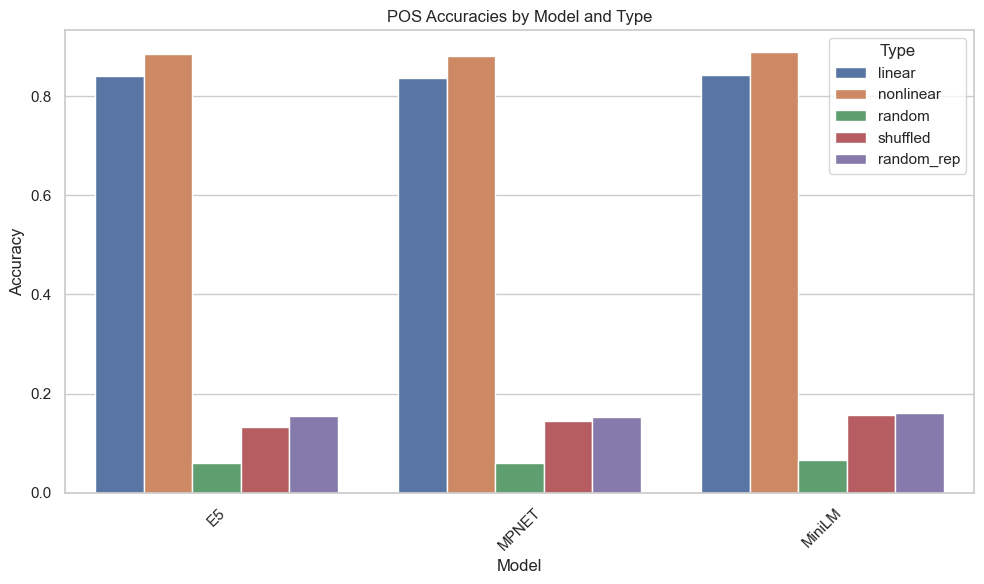

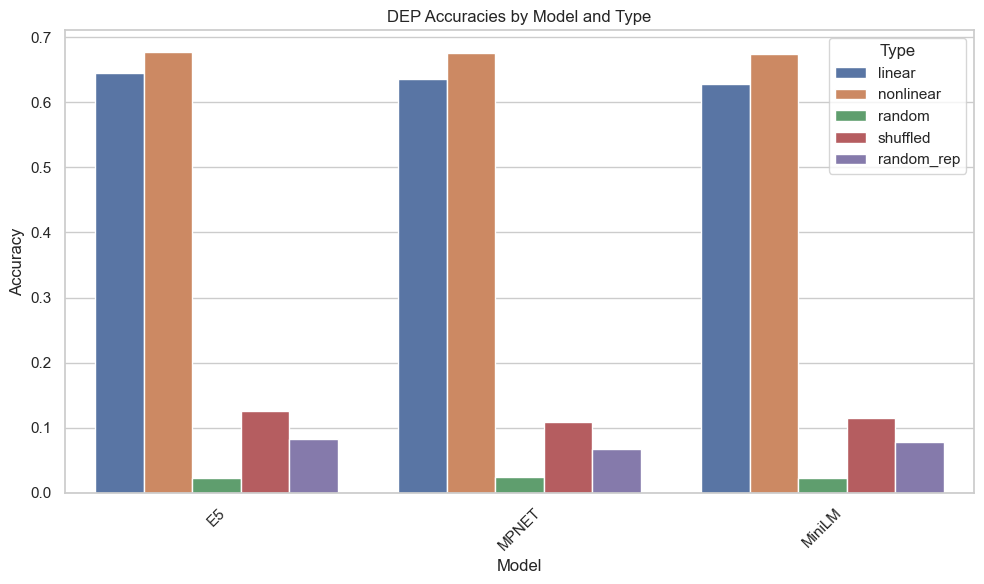

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
records = []
for model, tagsets in eval_results.items():
    for tag, values in tagsets.items():
        for val_type, acc in values.items():
            records.append({'Model': model, 'Tag': tag, 'Type': val_type, 'Accuracy': acc})

df = pd.DataFrame.from_records(records)

# Set seaborn style
sns.set(style="whitegrid")

# Function to plot a grouped bar chart for POS or DEP
def plot_seaborn_bar(tag_type):
    plt.figure(figsize=(10, 6))
    subset = df[df['Tag'] == tag_type]
    ax = sns.barplot(data=subset, x='Model', y='Accuracy', hue='Type')
    ax.set_title(f'{tag_type} Accuracies by Model and Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot POS and DEP
plot_seaborn_bar('POS')
plot_seaborn_bar('DEP')


In [55]:
import torch
import numpy as np

pos_model = probes_minilm['pos_linear']
weights_matrix = pos_model.linear.weight.detach().cpu().numpy()  # shape: (n_classes, d_embeddings)

U, sigma, VT = np.linalg.svd(weights_matrix, full_matrices=False)

print("U matrix shape:", U.shape)
print("Sigma (singular values) shape:", sigma.shape)
print("VT matrix shape:", VT.shape)

U matrix shape: (17, 17)
Sigma (singular values) shape: (17,)
VT matrix shape: (17, 384)


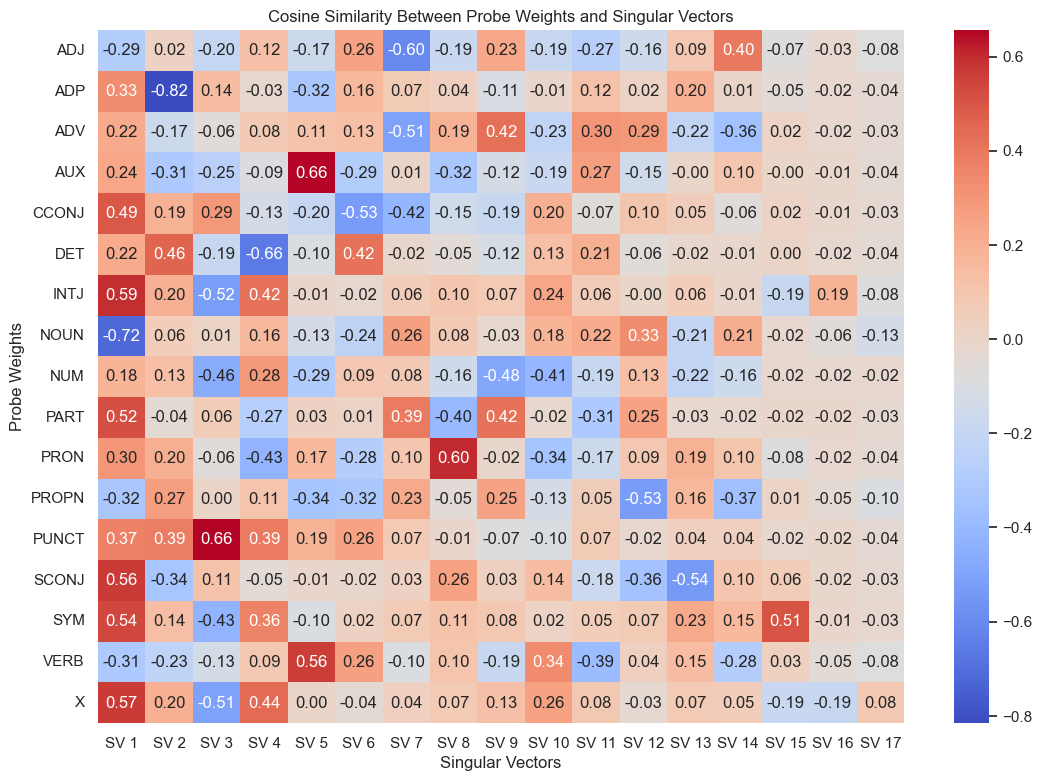

In [62]:
## Cosine similarity heatmap

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

cos_sim = cosine_similarity(weights_matrix, VT[:17, :])

plt.figure(figsize=(13, 9))
sns.heatmap(cos_sim, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=[f"SV {i+1}" for i in range(17)], yticklabels=le_pos.classes_)
plt.title("Cosine Similarity Between Probe Weights and Singular Vectors")
plt.xlabel("Singular Vectors")
plt.ylabel("Probe Weights")
plt.show()